<a href="https://colab.research.google.com/github/diegosanfuen/DeppLearningCienciaDeDatos/blob/main/Ejercicio_Practico_2_Diego_S%C3%A1nchez_de_la_Fuente_entrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Red Neuronal conjunto de datos MNIST - Diego Sánchez de la Fuente

In [1]:
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import cv2
from PIL import Image
import glob
import os
import time
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import random
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score

In [17]:
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error
from sklearn.neural_network import MLPRegressor
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from sklearn.linear_model    import LogisticRegression
from tensorflow.keras.utils  import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, callbacks
# Importamos los elementos de Keras que utilizaremos con mayor frecuencia
from keras.utils import image_dataset_from_directory
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization,
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast)
from tensorflow.keras.datasets import mnist

Rápidamente vemos que el modelo es capaz de alcanzar una tasa de acierto del 100% sobre los datos de validación. De esta manera comprobamos qué tan sencillo es diseñar y entrenar redes neuronales funcionales con Keras

In [3]:
# Importamos Tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necesitaremos GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# Keras version is 3.0.5
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.17.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  3.4.1


# **Actividad Evaluable 2.** Redes Neuronales Artificiales.

<img src="https://datasets.activeloop.ai/wp-content/uploads/2019/12/MNIST-handwritten-digits-dataset-visualized-by-Activeloop.webp" width=600px>

<p align="justify">Uno de los datasets más trabajados dentro del mundo de las Redes Neuronales es el <b>MNIST</b>. Un dataset conformado por imágenes de <i>28x28</i> píxeles de números escritos a mano y digitalizados, que ahora deberemos de aprender a clasificar <i>(similar al trabajo del Bloque 5)</i>. Hoy nuestra misión será aplicar el conocimiento aprendido en el diseño de Redes Neuronales con <b>Keras</b> para entrenar a nuestro clasificador.

---

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


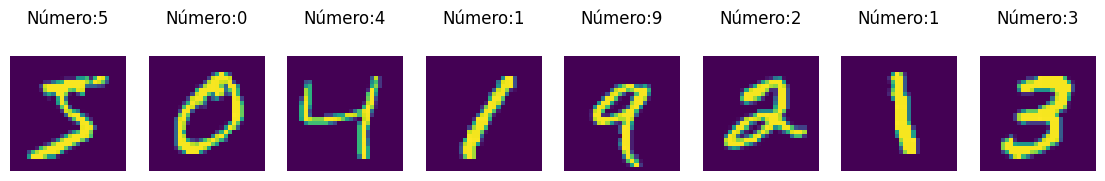

In [4]:
# Cargamos el dataset MNIST desde la librería de Keras.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Visualizamos alguno de los números del dataset.
fig, axs = plt.subplots(1, 8, figsize=(14, 2))
for i in range(len(axs)):
  axs[i].matshow(X_train[i])                     # Visualiza el número.
  axs[i].set_title('Número:' + str(Y_train[i]))  # Añade un título descriptivo.
  axs[i].axis('off')                             # Oculta los ejes de la gráfica.


# COMIENZA AQUÍ TU CÓDIGO

In [21]:
# Observamos los tipos de objetos y caracteristicas de los mismos, entrada y salida del modelo
print(f"Objeto de Entrada del modelo (Vector de caracteristicas) {type(X_train)}")
print(f"Objeto de Salida del modelo (Vector de clases) {type(Y_test)}")

# Rango de valores
print(f"Rango de valores en x_test: Mínimo = {np.min(X_train)}, Máximo = {np.max(X_train)}")
print(f"Rango de valores en y_test: Mínimo = {np.min(Y_test)}, Máximo = {np.max(Y_test)}")

Objeto de Entrada del modelo (Vector de caracteristicas) <class 'numpy.ndarray'>
Objeto de Salida del modelo (Vector de clases) <class 'numpy.ndarray'>
Rango de valores en x_test: Mínimo = 0, Máximo = 255
Rango de valores en y_test: Mínimo = 0, Máximo = 9


In [8]:
# Utilizamos el MinMaxScaler para normalizar los datos a un rango [0, 1]
scaler = MinMaxScaler()

# Aplicar MinMaxScaler a los datos (aplanando antes las imagenes)
x_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
x_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

In [18]:
# Adaptamos la forma de los vectores de entrada a (28x28x1) pra que sea valida para el modelo
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# Modelo CNN (Red Neuronal Convolucional)
model = models.Sequential([
    # Primera capa convolucional
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    # Capa de Pooling
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Segunda capa convolucional
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    # Capa de Pooling
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Tercera capa convolucional
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),

    # Aplanamos para ingresar en la red completamente conectada
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 clases para los dígitos del 0 al 9
])

# Compilamos el modelo
# Como métrica usamos la entropia cruzada para la métrica usamos la precisión
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Definir EarlyStopping con una paciencia de 5 épocas métrica val_loss (es decir si durante 5 épocas la perdida de la validación no disminuye)
# con restauracion de los mejores parametros
condicion_parada = callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5,
                                           restore_best_weights=True)

# Entrenar el modelo
historico_model = model.fit(x_train, Y_train, epochs=50,
                            callbacks=[condicion_parada],
                            validation_data=(x_test, Y_test),)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(x_test, Y_test)
print(f'\nPrecisión en el conjunto de prueba: {test_acc:.4f}')

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8858 - loss: 0.3571 - val_accuracy: 0.9857 - val_loss: 0.0464
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9852 - loss: 0.0471 - val_accuracy: 0.9883 - val_loss: 0.0349
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9908 - loss: 0.0304 - val_accuracy: 0.9916 - val_loss: 0.0280
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9919 - loss: 0.0262 - val_accuracy: 0.9910 - val_loss: 0.0334
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9939 - loss: 0.0185 - val_accuracy: 0.9906 - val_loss: 0.0308
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9955 - loss: 0.0145 - val_accuracy: 0.9903 - val_loss: 0.0348
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9959 - loss: 0.0119 - val_accuracy: 0.9906 - val_loss: 0.0298
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9969 - loss: 0.0088 

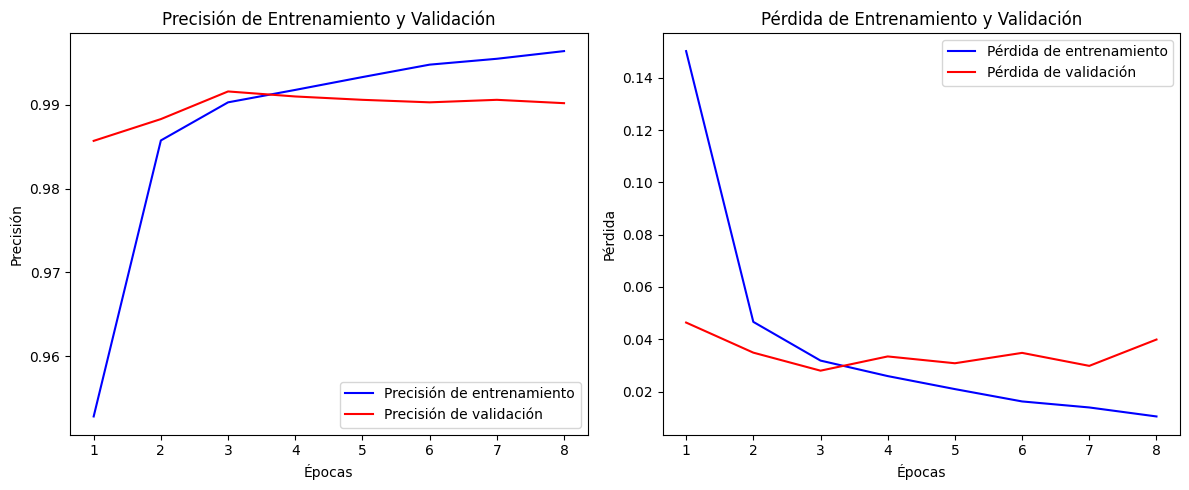

In [19]:
# Graficar la precisión y el error durante el entrenamiento y la validación
def plot_history(historico):
    # Extraer la precisión y la pérdida
    acc = historico.history['accuracy']
    val_acc = historico.history['val_accuracy']
    loss = historico.history['loss']
    val_loss = historico.history['val_loss']

    # Crear las figuras de precisión y pérdida
    epochs = range(1, len(acc) + 1)

    # Gráfico de Precisión
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Precisión de entrenamiento')
    plt.plot(epochs, val_acc, 'r', label='Precisión de validación')
    plt.title('Precisión de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Gráfico de Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='Pérdida de validación')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
plot_history(historico_model)

Observamos que no hay Overfiting en el modelo de red neuronal convolucional anterior, ya que las precisiones de la validación como del entrenamiento son muy similares, decayendo ligeramente en las últimas épocas la precisión del entrenamiento.

Por otro lado con 6 épocas hemos conseguido una precisión del 99%.